## DM-28157 Frequency cutting based on the estimated PSF and solution radiuses

We test cutting for the the numerator PSF tail frequency or at the solution convergence radius whichever is smaller.

We try to replace with a "smoother" value if the convergence limit is not reached in the theoretical solution.

## Conclusion

In this notebook we demonstrate that it's not enough to determine cutting frequencies for the PSFs as the fc1, fc2 theoretical solutions are not guaranteed to have reached their limit values at these points. -> TODO: we perhaps should not replace it by one value but with a "theoretical solution tail"

### Notations

$fc_1$, $fc_2$: Matching kernels in Fourier space.
$c_1$, $c_2$: Matching kernels for the input images A, B in image space. 

$P_d$ : the PSF of the difference image, the result of the PSF matching for both images.

$\sigma_1$, $\sigma_2$: The PSF sigma (width) of Gaussian image PSFs in _image space_.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
%run -b -i "array_freq_cut.py"
%run -b -i "TwoD_gaussian_in_freq_space.py"

In [2]:
from lsst.ip.diffim.zogy import ZogyTask, ZogyConfig
config = ZogyConfig()
config.scaleByCalibration = False
task = ZogyTask(config=config)

Create a test mask array

In [32]:
# We assume wSig1 > wSig2 in the limit values here
wSig1 = 3.31
wSig2 = 3.3
fourPiSq = 4. * np.pi * np.pi

In [33]:
fr1, fr2 = calculateCutFrequencies(wSig1, wSig2, 100, 100, limit=0.999999)
print(fr1, fr2)
print(fr1 * 1024, fr2 * 1024)
frp1 = calculateGaussianCutFrequency(wSig1, limit=0.999999)
frp2 = calculateGaussianCutFrequency(wSig2, limit=0.999999)
print (frp1, frp2)
print (frp1 * 1024, frp2 * 1024)

0.808 0.808
827.392 827.392
Freq space sigma: 0.04808306437821611
Freq space sigma: 0.04822877063390768
0.232 0.232
237.568 237.568


## 31x31 PSFs padded and FFTd
Pad a usual 31x31 pix. PSF then FFT them

In [34]:
A = calculate2dGaussianArray(31, 31, wSig1)
pA = task.padCenterOriginArray(A,(1024,1024))
psf1 = np.fft.fft2(pA)
B = calculate2dGaussianArray(31, 31, wSig2)
pB = task.padCenterOriginArray(B,(1024,1024))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


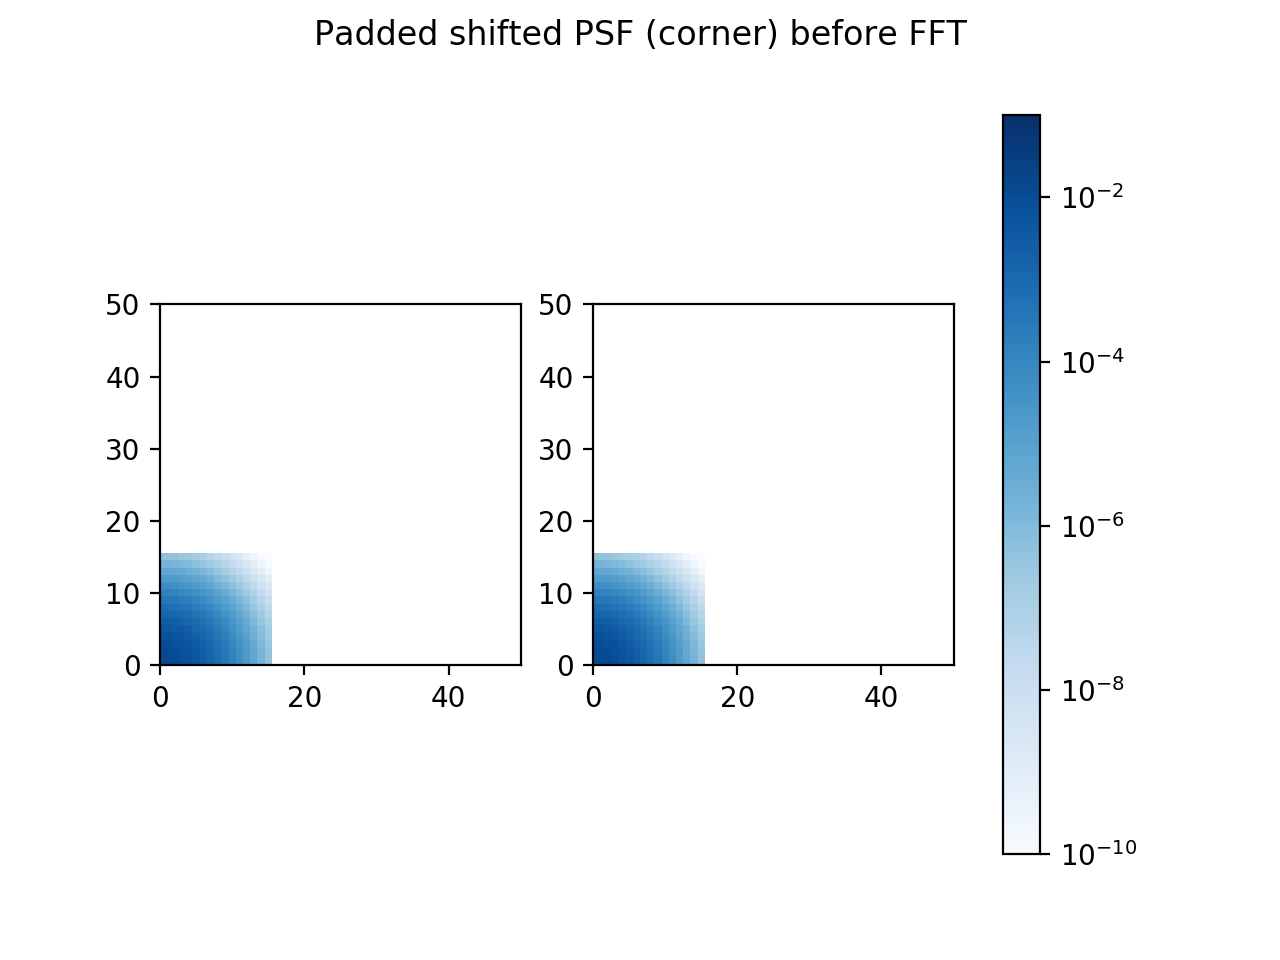

Text(0.5, 0.98, 'Padded shifted PSF (corner) before FFT')

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(pA, origin='bottom', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(pB, origin='bottom', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
fig.colorbar(cs, ax=[ax1, ax2])
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 50)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 50)
fig.suptitle("Padded shifted PSF (corner) before FFT")

<IPython.core.display.Javascript object>


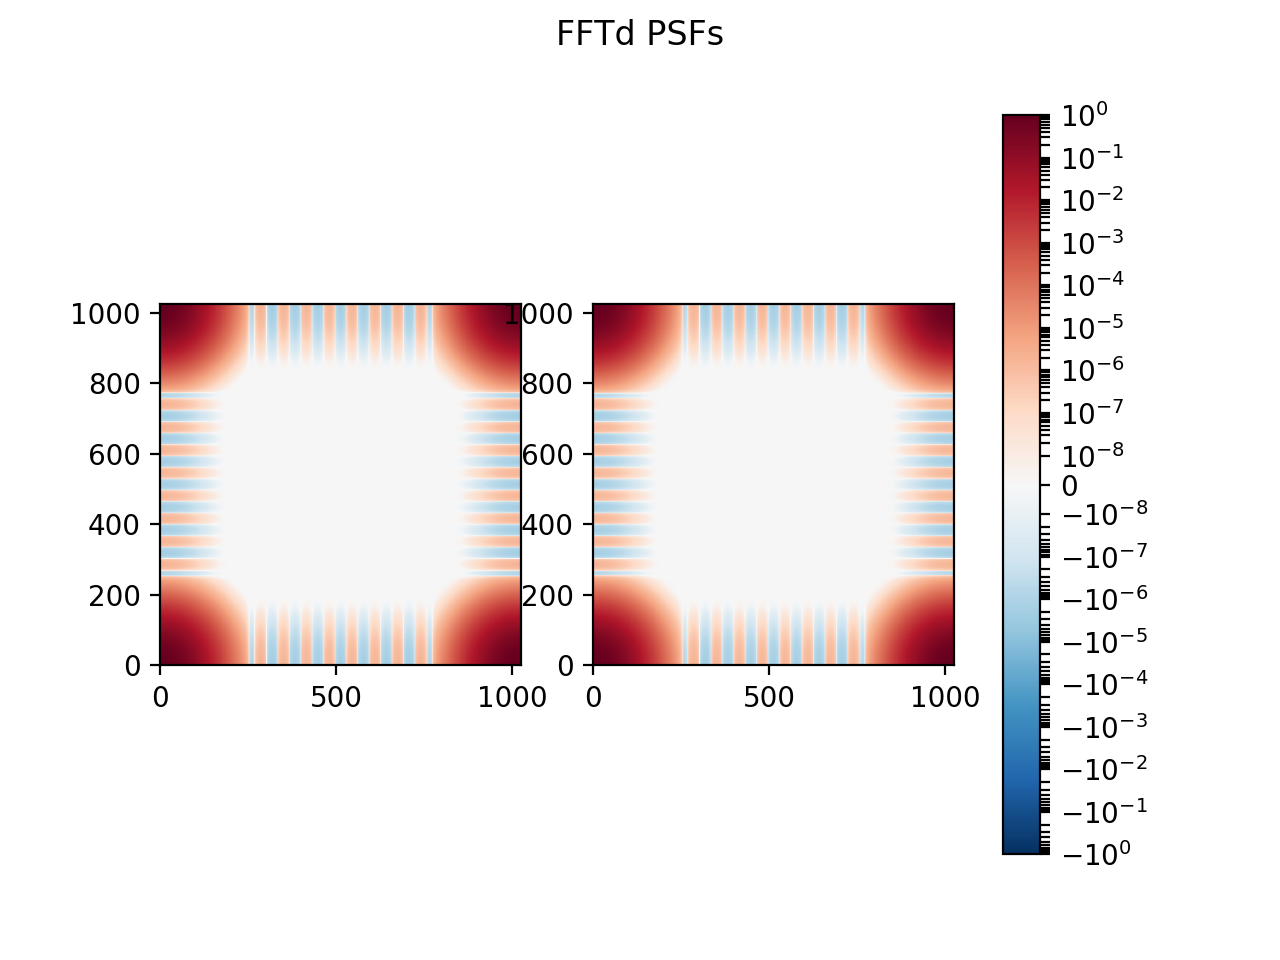

Text(0.5, 0.98, 'FFTd PSFs')

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(psf1.real, origin='bottom', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(psf2.real, origin='bottom', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
fig.colorbar(cs, ax=[ax1, ax2])
fig.suptitle("FFTd PSFs")

There are some small negative values around in the frequency space PSFs.

In [37]:
# Noise variance in the images
varMean1 = 100
varMean2 = 100
F1 = 1.
F2 = 1. 
var1F2Sq = varMean1*F2*F2
var2F1Sq = varMean2*F1*F1
FdDenom = np.sqrt(var1F2Sq + var2F1Sq)  # one number
# We need reals for comparison, also real operations are usually faster
# Psf absolute squared
psfAbsSq1 = np.real(np.conj(psf1)*psf1)
psfAbsSq2 = np.real(np.conj(psf2)*psf2)
sDenom = var1F2Sq*psfAbsSq2 + var2F1Sq*psfAbsSq1  # array, eq. (12)
# sDenom close to zero check here in the code, here we ignore, we won't hit division by zero
denom = np.sqrt(sDenom)  # array, eq. (13)

sDenom: The squared denominator in the difference image calculation

In [38]:
fPd = FdDenom*psf1*psf2/denom  # Psf of D eq. (14)
fc1 = psf2/denom
fc2 = psf1/denom

In [39]:
print(FdDenom)

14.142135623730951


Check all are real.

In [40]:
print(np.all(fPd.imag == 0), np.all(fc1.imag == 0), np.all(fc2.imag == 0))

True True True


<IPython.core.display.Javascript object>


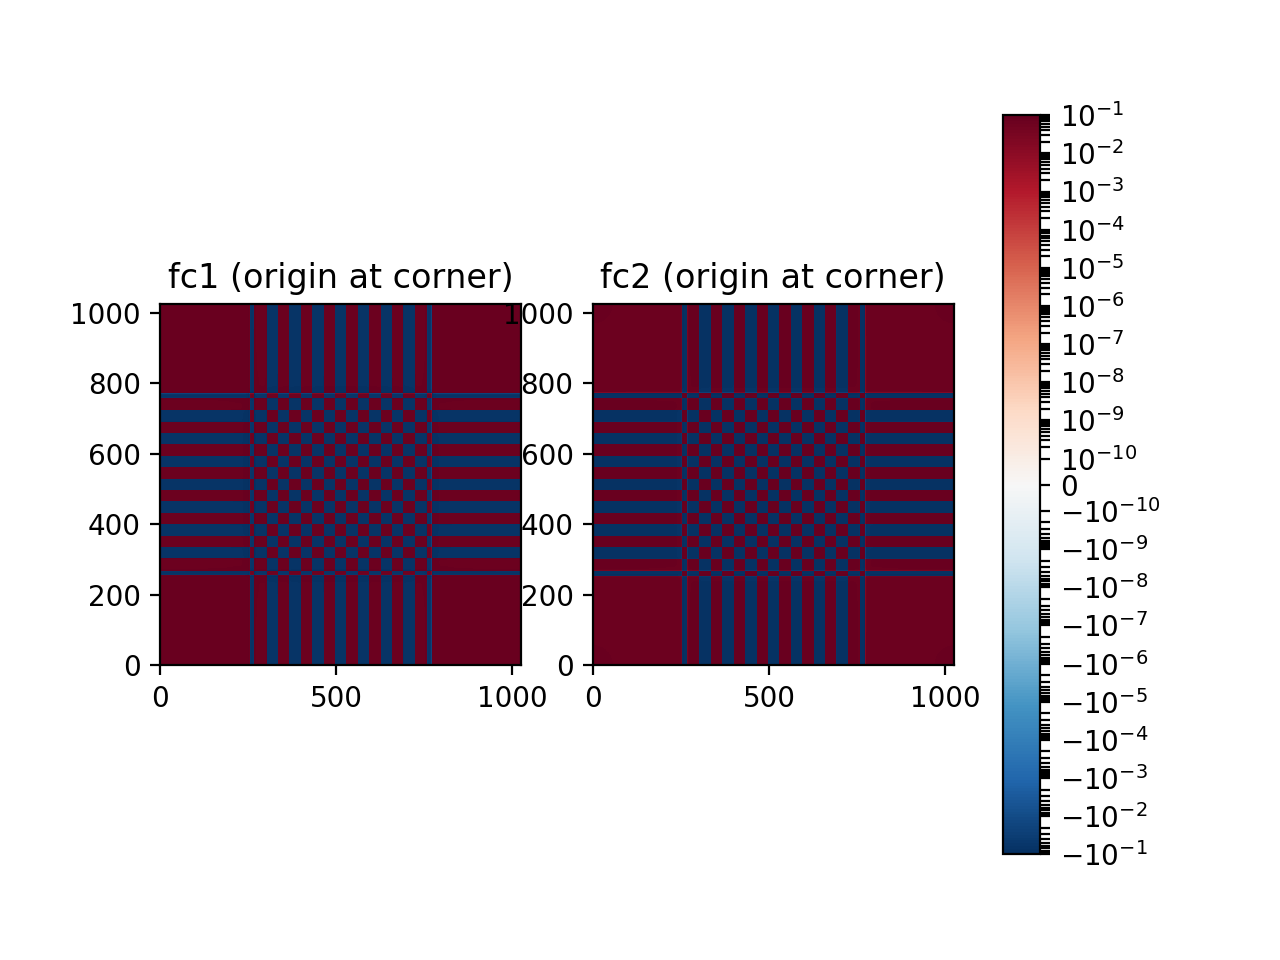

fc1 min -0.09808652839197012
fc1 max 0.099913704358885
fc2 min -0.09853325423300521
fc2 max 0.099913704358885


In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax1.set_title("fc1 (origin at corner)")
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(fc2.real, origin='bottom', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax2.set_title("fc2 (origin at corner)")
fig.colorbar(cs, ax=[ax1, ax2])
print(f"fc1 min {np.min(fc1.real)}")
print(f"fc1 max {np.max(fc1.real)}")
print(f"fc2 min {np.min(fc2.real)}")
print(f"fc2 max {np.max(fc1.real)}")

The matching kernel for the wider input PSF

<IPython.core.display.Javascript object>


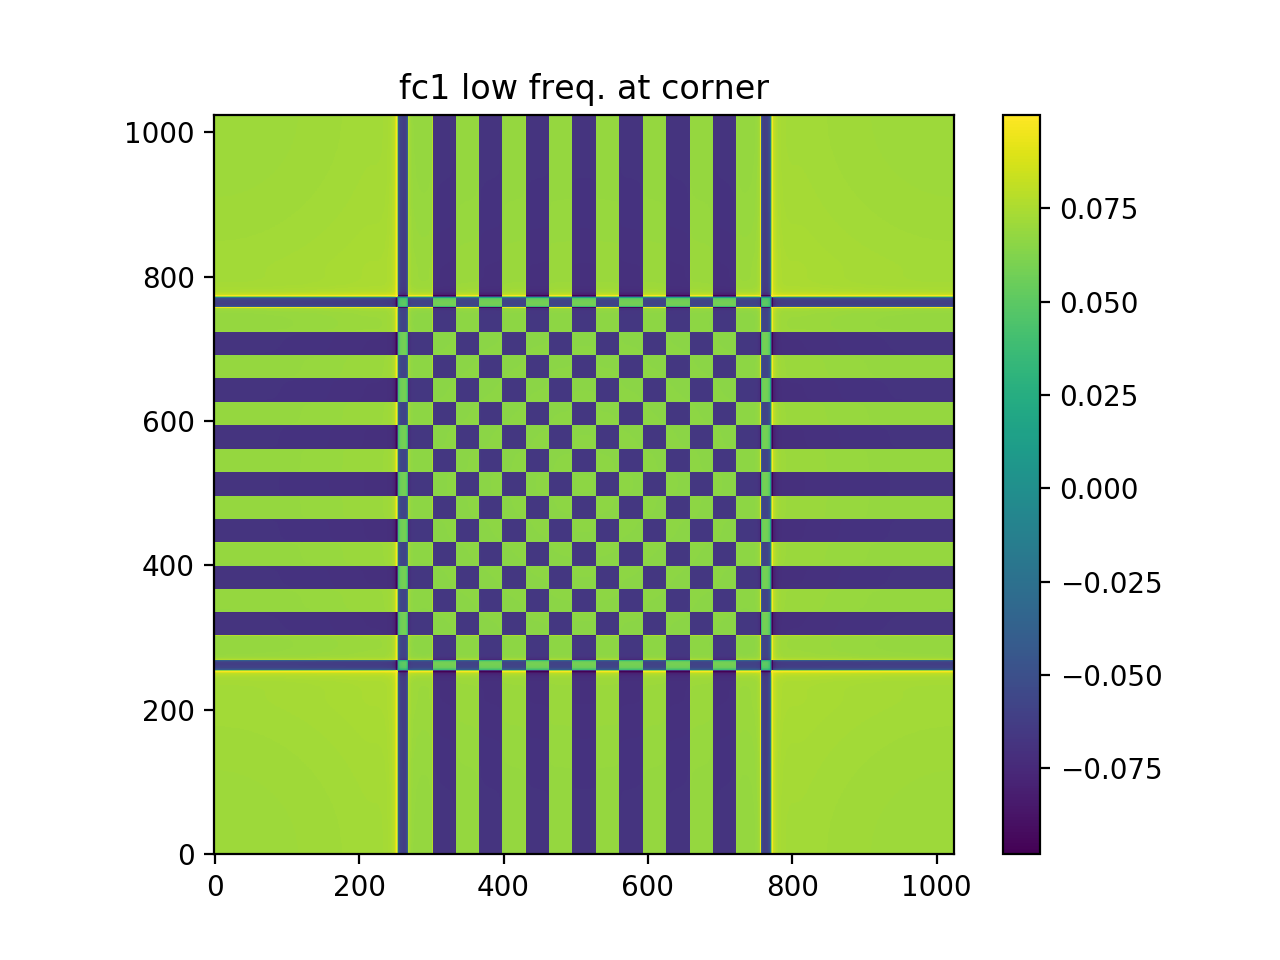

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

In [43]:
r = np.minimum(fr1, frp2)
rN = np.minimum(fr1, frp2) * 1024
freqFlt1 = makeEllipseQuartersMaskArray((1024, 1024), rN , rN)
sqDiffWidth = wSig1*wSig1 - wSig2*wSig2
flim1 = 1./(F1 * np.sqrt(varMean1/(F1*F1) + varMean2/(F2*F2) * np.exp(-fourPiSq*sqDiffWidth*r)))

<IPython.core.display.Javascript object>


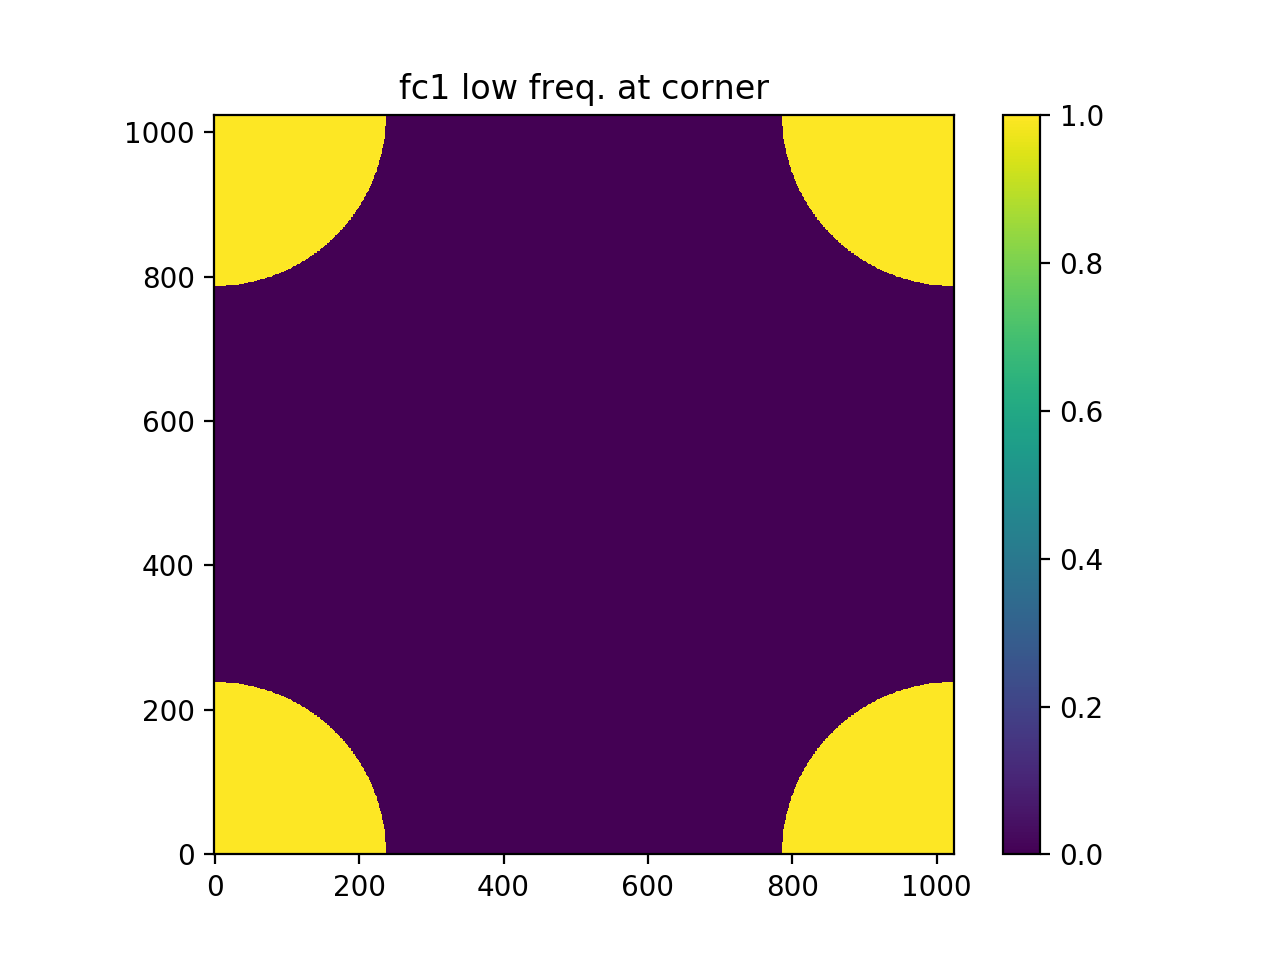

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt1, dtype=int), origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

In [46]:
print(flim1)

0.08042965380459527


In [47]:
freqFlt1 = np.logical_not(freqFlt1)
# fc1.real[freqFlt1] = 1./np.sqrt(varMean1)
fc1.real[freqFlt1] = flim1

<IPython.core.display.Javascript object>


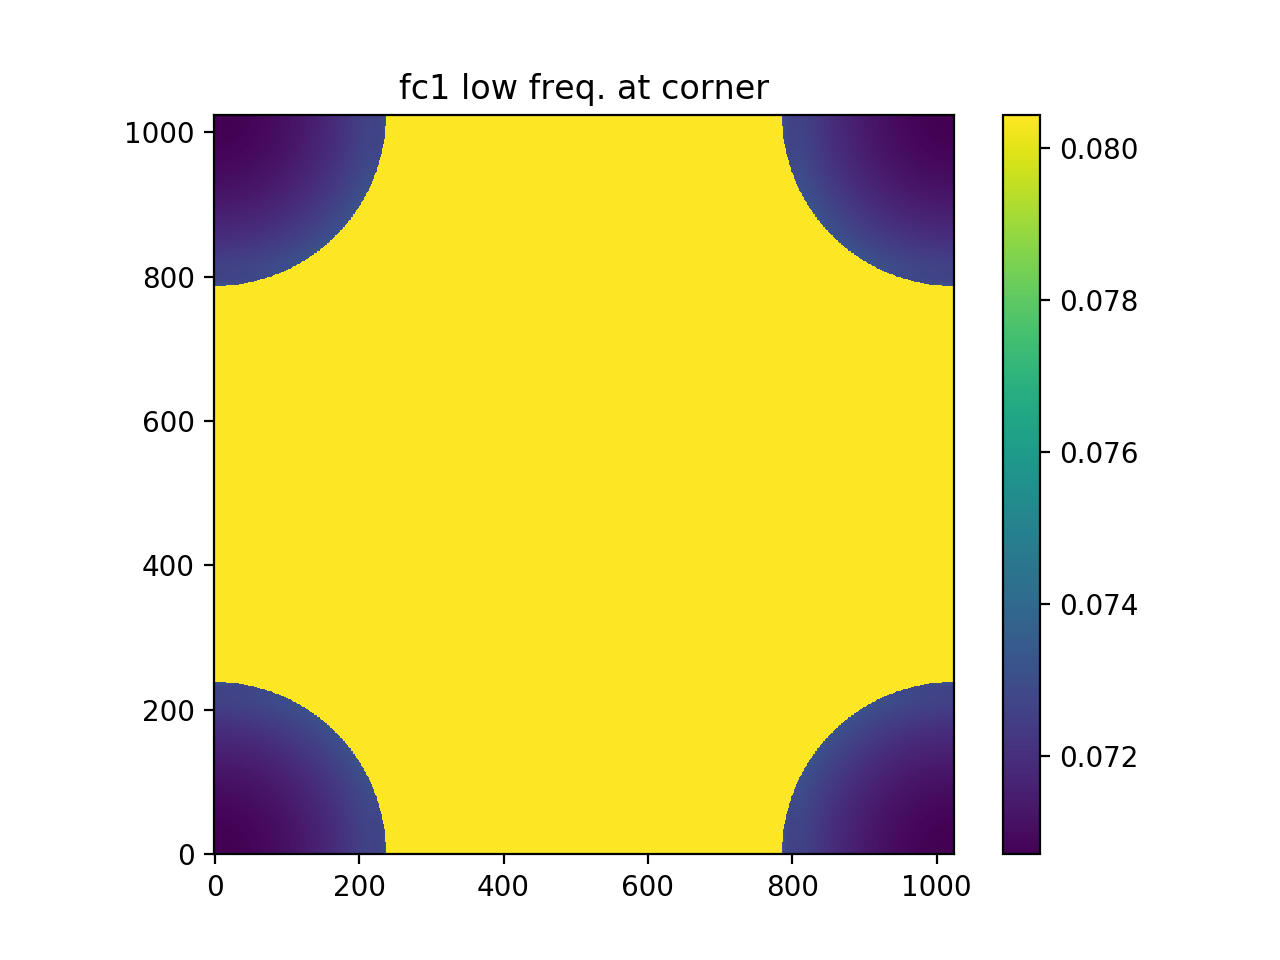

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

The matching kernel for the narrower input PSF

<IPython.core.display.Javascript object>


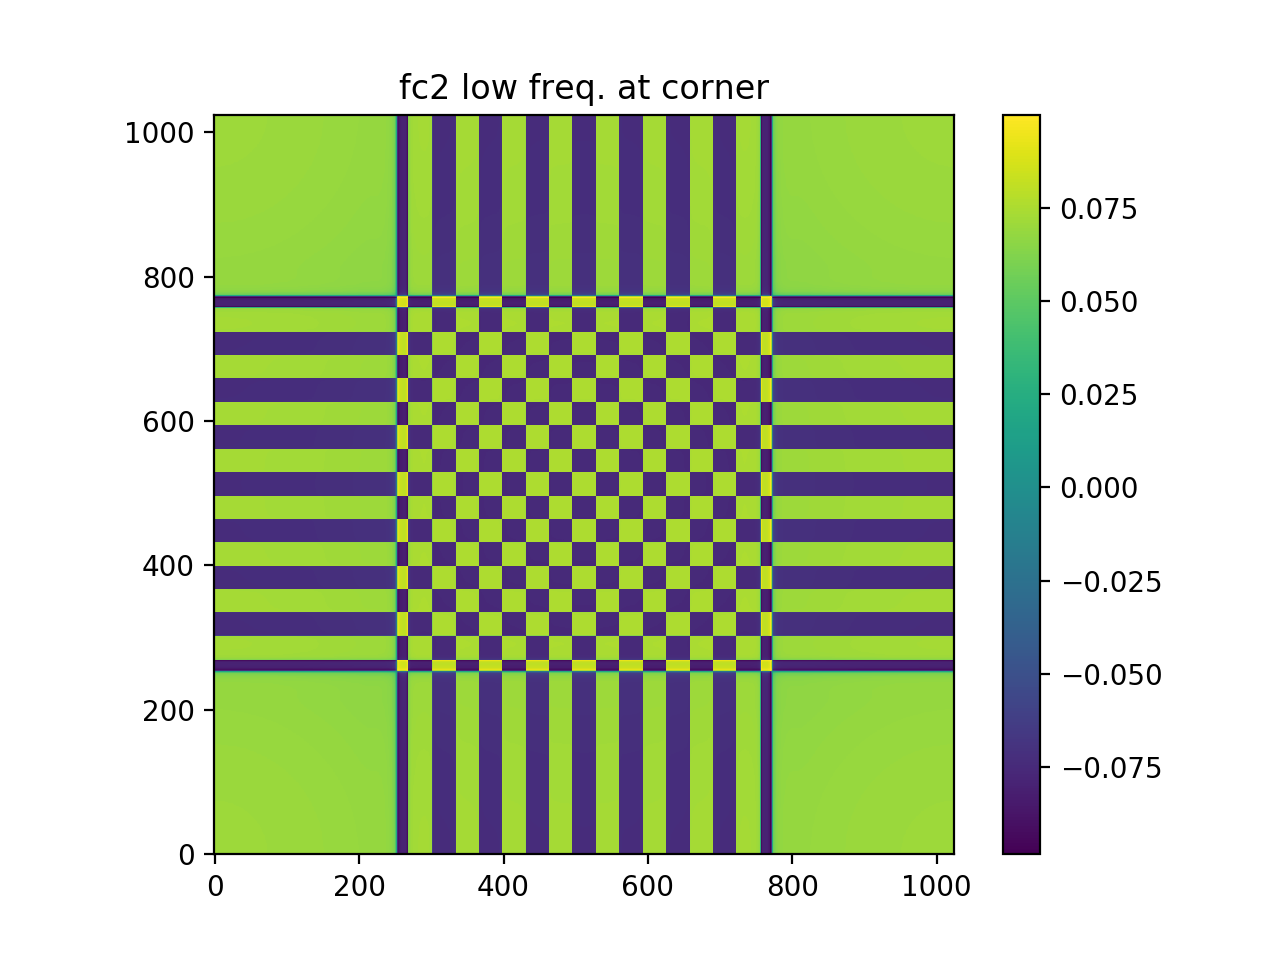

In [49]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='bottom', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

In [50]:
r = np.minimum(fr2, frp1)
rN = np.minimum(fr2, frp1) * 1024
freqFlt2 = ellipseMaskArrayQuarter((1024, 1024), rN , rN)
flim2 = 1./(F2 * np.sqrt(varMean2/(F2*F2) + varMean1/(F1*F1) * np.exp(fourPiSq*sqDiffWidth*r)))

In [51]:
print(r, flim2)

0.232 0.05942281370713568


<IPython.core.display.Javascript object>


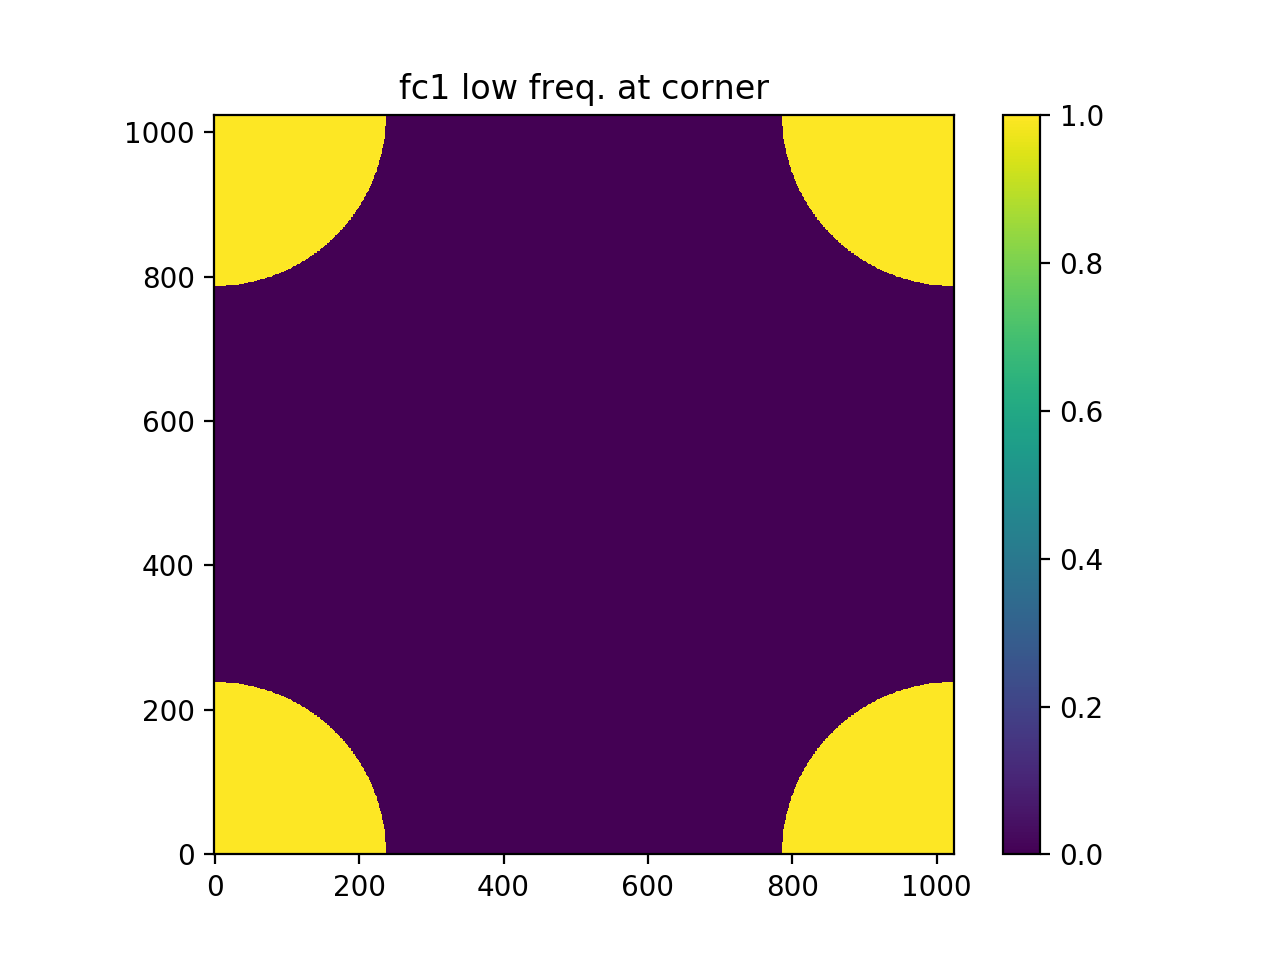

In [52]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt2, dtype=int), origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

In [53]:
freqFlt2 = np.logical_not(freqFlt2)
#fc2.real[freqFlt2] = 0.
fc2.real[freqFlt2] = flim2

<IPython.core.display.Javascript object>


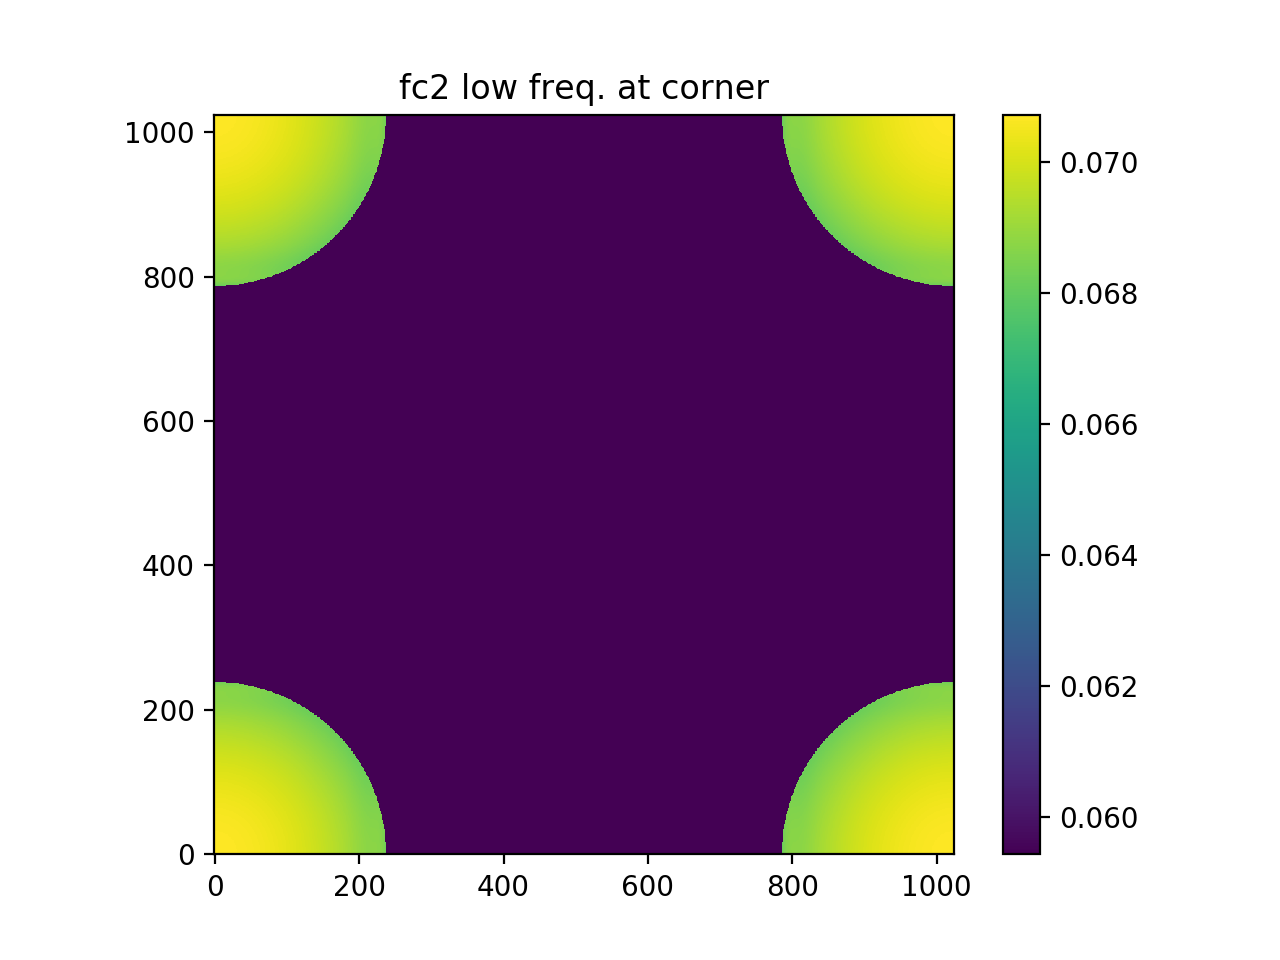

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='bottom', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

In [55]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
c2 = np.real(np.fft.ifft2(fc2))

The matching kernel for the wider input back in image space

<IPython.core.display.Javascript object>


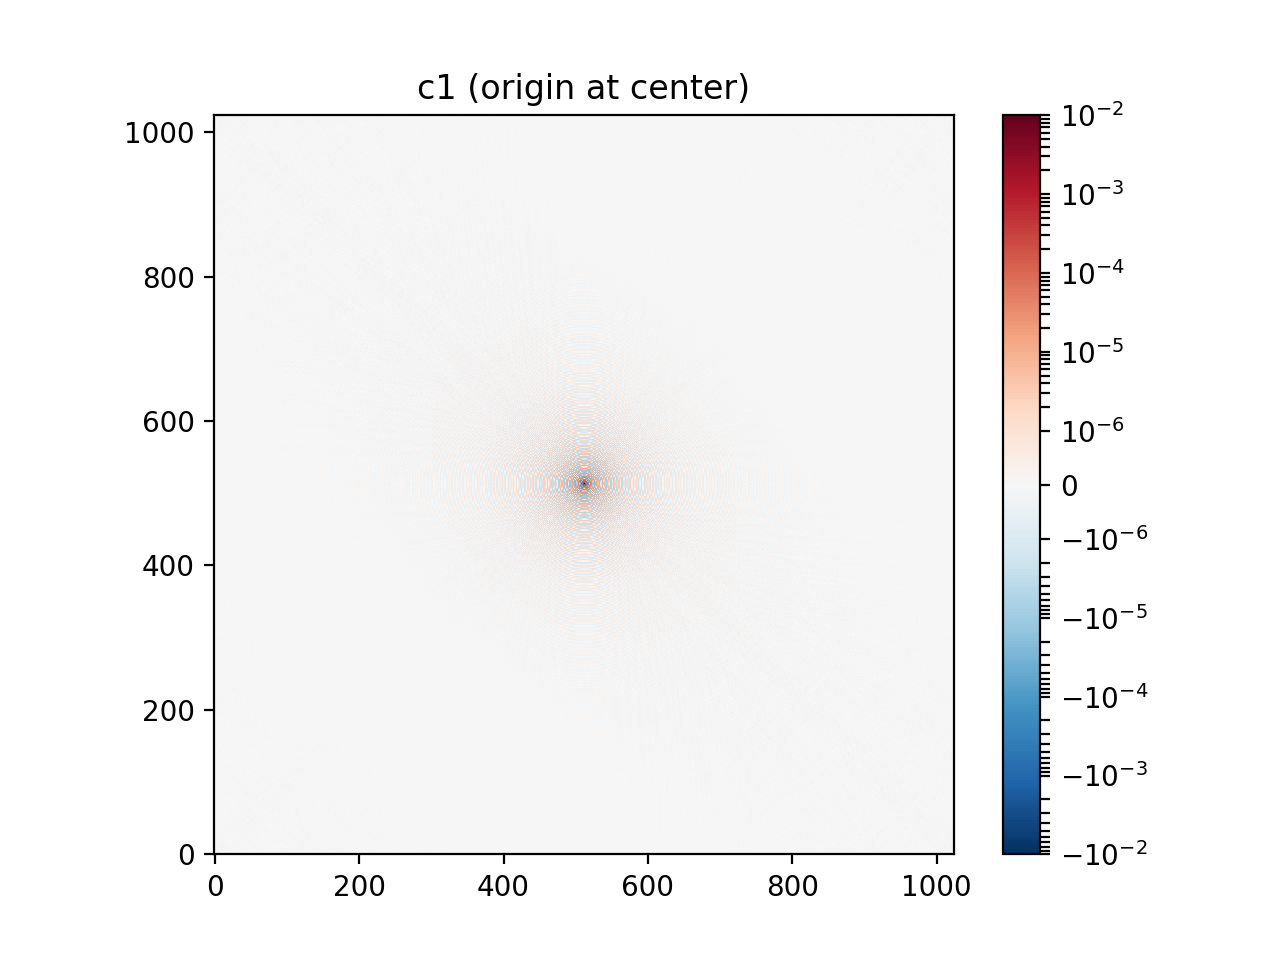

Text(0.5, 1.0, 'c1 (origin at center)')

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1 (origin at center)")

And for the narrower one

<IPython.core.display.Javascript object>


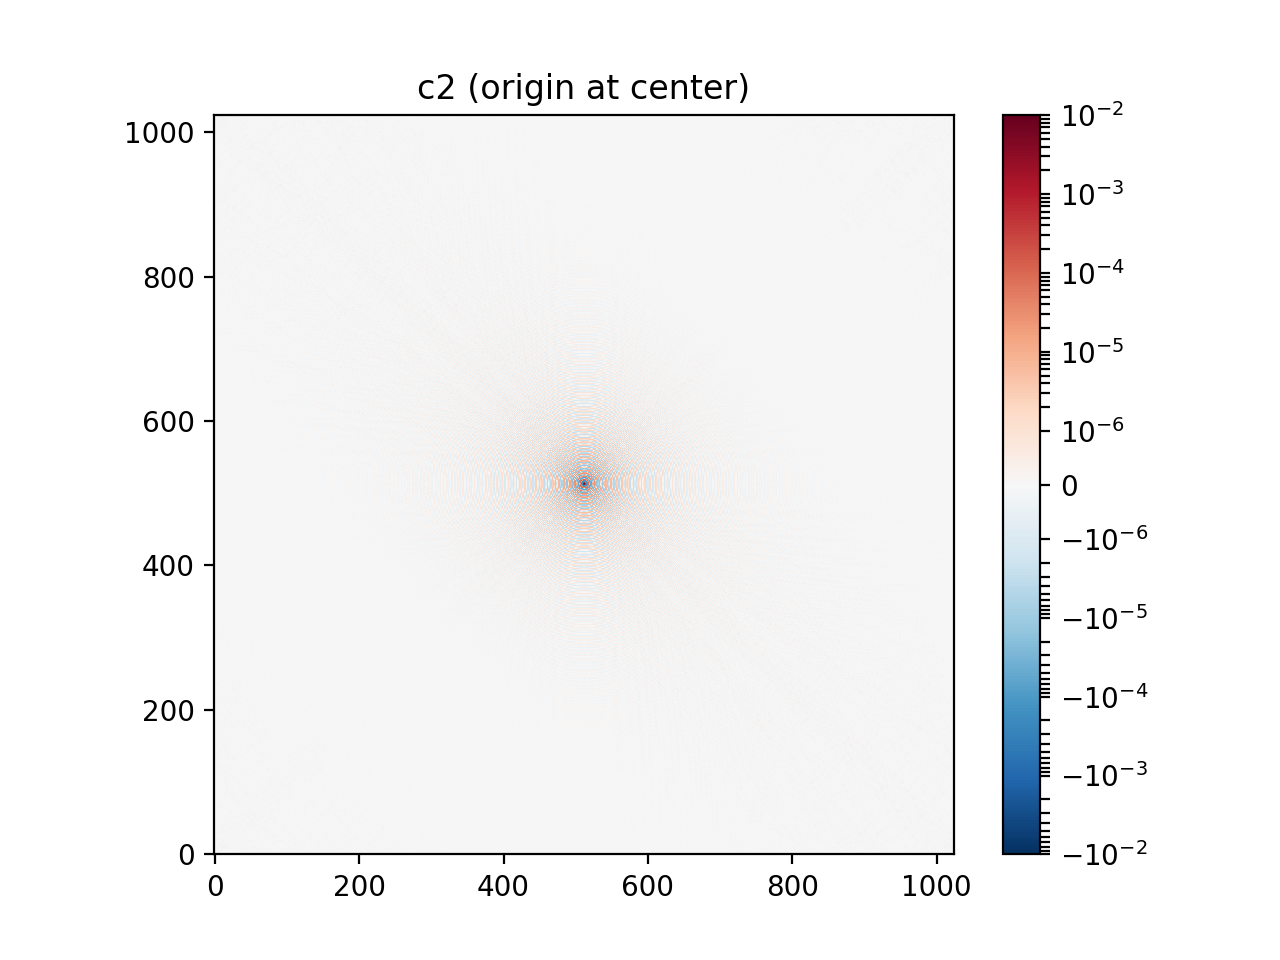

Text(0.5, 1.0, 'c2 (origin at center)')

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c2, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c2 (origin at center)")

PSF for the difference image

<IPython.core.display.Javascript object>


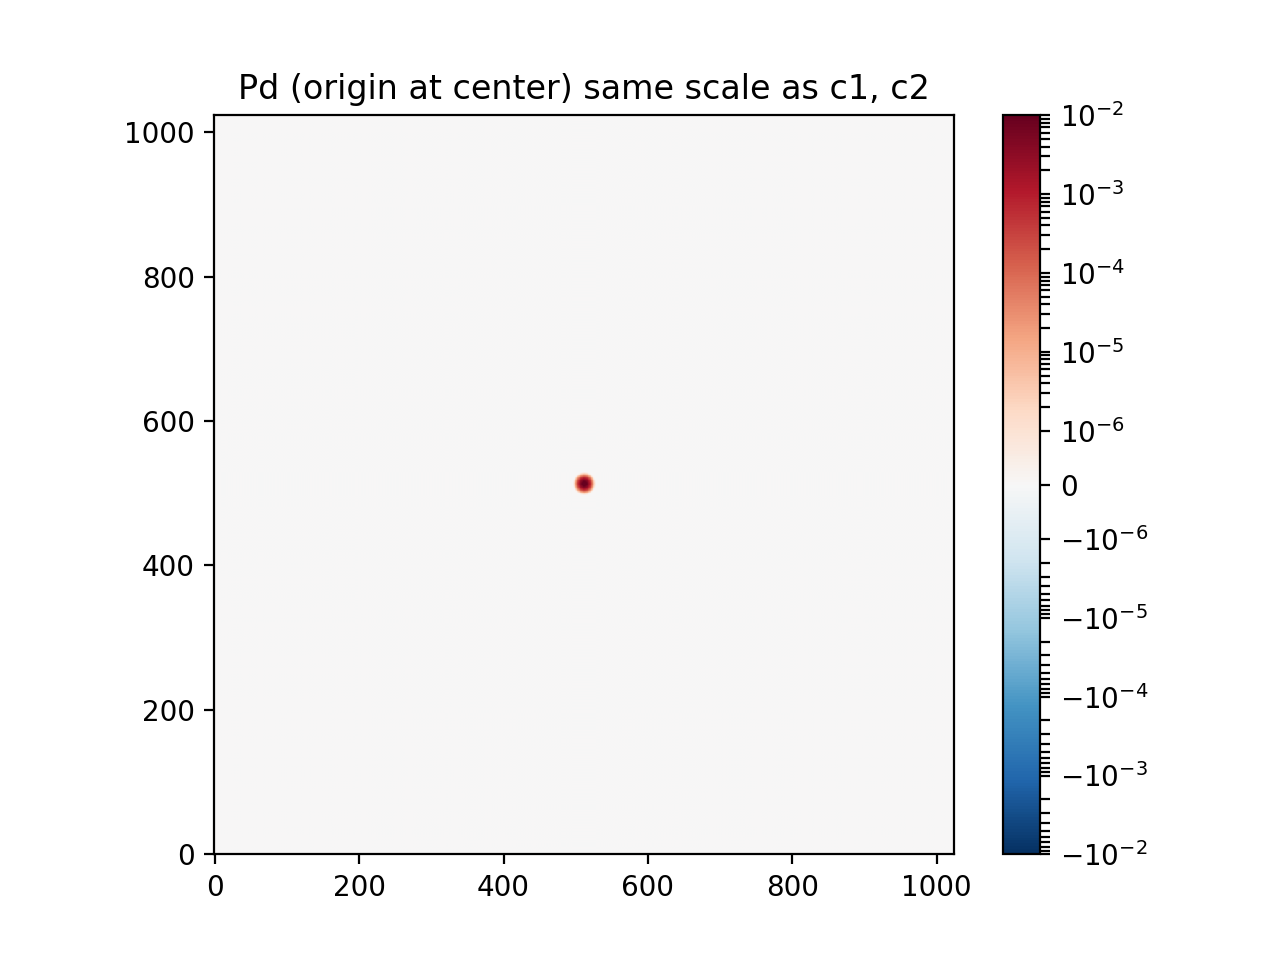

Text(0.5, 1.0, 'Pd (origin at center) same scale as c1, c2')

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("Pd (origin at center) same scale as c1, c2")

<IPython.core.display.Javascript object>


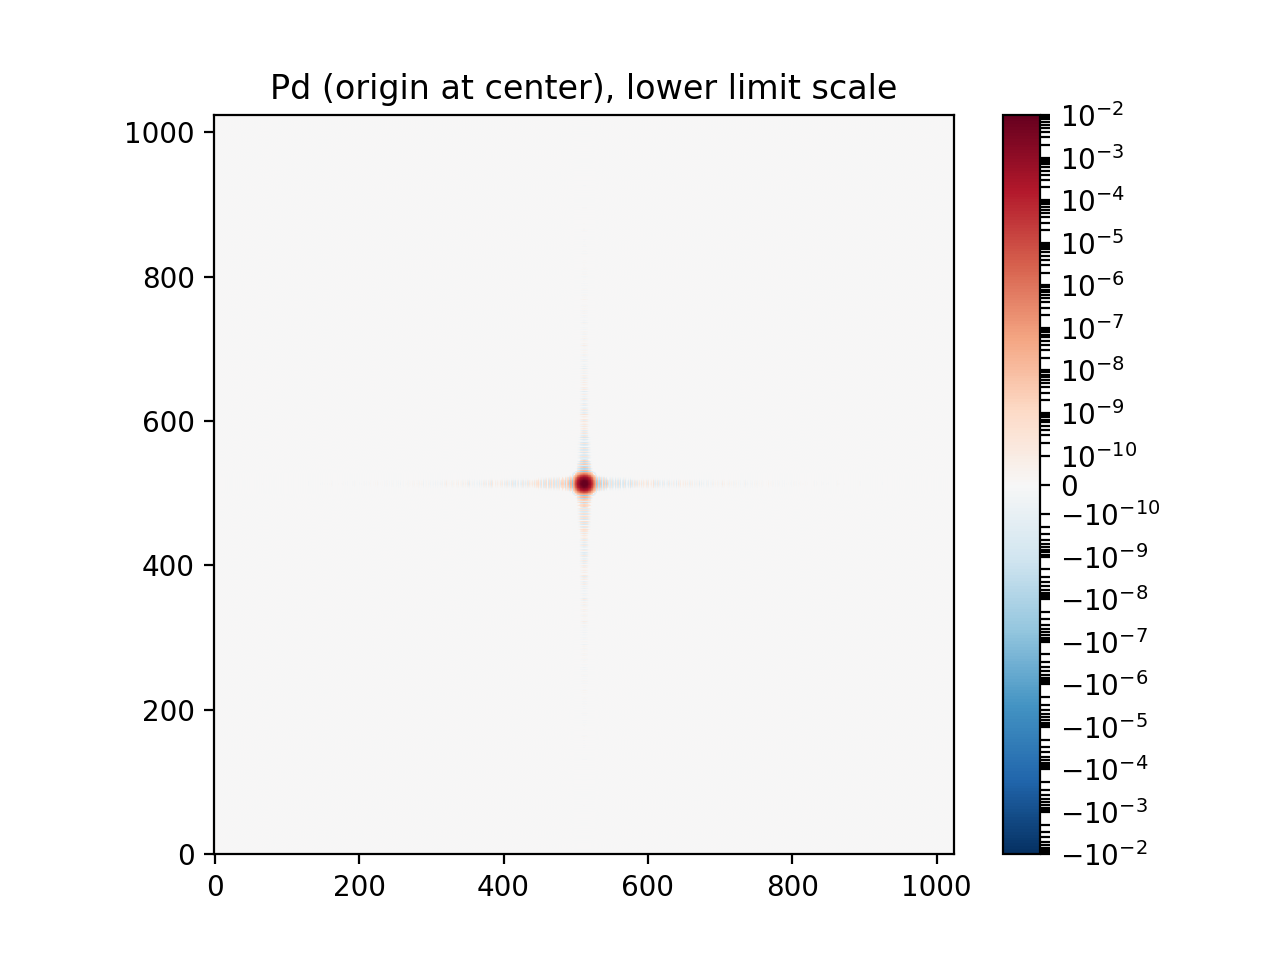

Text(0.5, 1.0, 'Pd (origin at center), lower limit scale')

In [455]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("Pd (origin at center), lower limit scale")